In [1]:
import numpy as np
from torchvision import datasets, transforms
from collections import defaultdict,Counter
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis,LinearDiscriminantAnalysis
from sklearn.covariance import EmpiricalCovariance
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from skimage.feature import hog
from skimage import data, exposure
from model import GDA,LDA
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
'''
Note: If this is you first time running, set download = True
'''
train_set = datasets.FashionMNIST("data",True, download = False)
test_set = datasets.FashionMNIST('data', train=False, download = False)

In [3]:
'''
Convert Data to numpy
Standardize the data
'''
scaler = MinMaxScaler()
x_tr = train_set.data.numpy().reshape(60000,-1)
x_tr = scaler.fit_transform(x_tr)
target_tr =  train_set.targets.numpy()

x_te = test_set.data.numpy().reshape(10000,-1)
x_te = scaler.transform(x_te)
target_te = test_set.targets.numpy()

In [4]:
#helper function to get accuracy
def acc(pred,target):
    return sum(pred == target)/ len(target)

# Naive Attempt: Run GDA on the images

In [5]:
clf = GDA()
clf.fit(x_tr, target_tr)

AssertionError: 

Here we failed the assertion that checks if the covariance is singular; this happens when we try to estimate the covariance matrix in high dimensions. Oftentimes some of the dimensions are collinear; they are potentially linear combinations of other dimensions. We will now use PCA to reduce the dimensions of the images avoid this issue

In [7]:
'''
Plot the accuracy of a model (gda/lda) with varying number of principal components
'''
def plot_results(components = [5,15,45,60,70] ,model = "gda"):
    
    res = []
    for component in components:
        clf = GDA() if model == "gda" else LDA()
        pca = PCA(n_components=component)
        clf.fit(pca.fit_transform(x_tr), target_tr)
        pred = clf.predict(pca.transform(x_te))
        acc_ = acc(pred,target_te)
        res.append(acc_)
    p = sns.lineplot(x = components,y = res,marker="o")
    p.set_xlabel("# of Principal Components", fontsize = 10)
    p.set_ylabel("Accuracy (%)", fontsize = 10)
    p.set_title(f"Result of {model}")
    return res

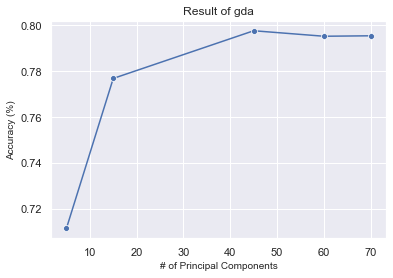

In [7]:
res = plot_results()

## Here we see how the accuracy of GDA changes with the number of principal components.

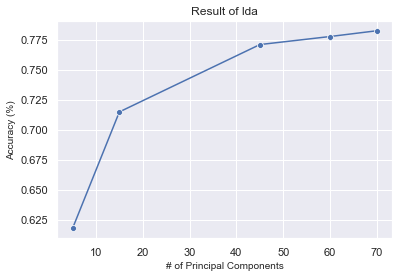

In [8]:
res = plot_results(model = "lda")

# Next, We will perform some error anaylsis on the best model

In [9]:
clf = GDA()
pca = PCA(n_components=45)
clf.fit(pca.fit_transform(x_tr), target_tr)
pred = clf.predict(pca.transform(x_te))
acc_ = acc(pred,target_te)
print(acc_)

0.7986


<AxesSubplot:>

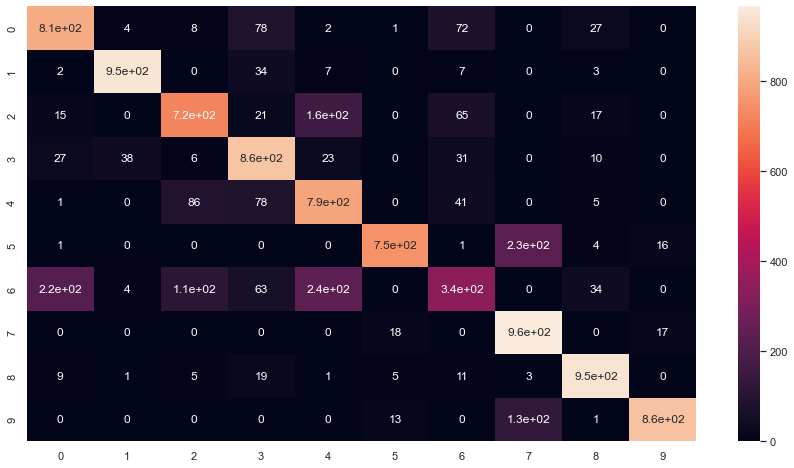

In [10]:
cf = confusion_matrix(target_te,pred)
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(cf, annot=True)


In [11]:
print("class  accuracy")
for i in range(len(cf)):
    rowsum = sum(cf[i])   
    
    print(" ", i,"   ",cf[i][i]/rowsum)

class  accuracy
  0     0.808
  1     0.947
  2     0.718
  3     0.865
  4     0.789
  5     0.75
  6     0.338
  7     0.965
  8     0.946
  9     0.86


Since the model is getting a lot of false negatives for the label 6, we will plot some images where the true label is a 6 but the model did not predict it as a 6

In [12]:
incorrect = []
for i,(yhat,y) in enumerate(zip(pred,target_te)):
    if(y==6 and yhat!= y):
        #stores the index and the incorrect prediction made by model
        incorrect.append((i,yhat))
idx2class = {v: k for k,v in train_set.class_to_idx.items()}

True Label: Shirt, Predicted: Dress


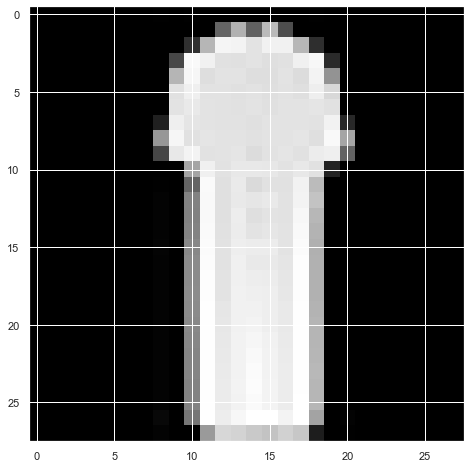

In [13]:
i = 7
print(f"True Label: {idx2class[6]}, Predicted: {idx2class[incorrect[i][1]]}")
plt.imshow(x_te[incorrect[i][0]].reshape(28,28),cmap='gray')


Now we will try to change the input space, instead of the images, we will input the HOG features. Since this is not a CV class, take for granted that HOG gives us a different feature

In [14]:
#function to get hog features
def get_hog_feat(images):
    hog_feat = []
    for img in images:
        feat = hog(img, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1))
        hog_feat.append(feat)
    return np.stack(hog_feat)

In [15]:
hog_tr = get_hog_feat(train_set.data.numpy())
hog_te = get_hog_feat(test_set.data.numpy())

In [16]:
clf = GDA()
pca = PCA(n_components=45)
clf.fit(pca.fit_transform(hog_tr), target_tr)
pred = clf.predict(pca.transform(hog_te))
acc_ = acc(pred,target_te)
print(acc_)

0.8101


In [17]:
incorrect = []
for i,(yhat,y) in enumerate(zip(pred,target_te)):
    if(y==6 and yhat!= y):
        #stores the index and the incorrect prediction made by model
        incorrect.append((i,yhat))
idx2class = {v: k for k,v in train_set.class_to_idx.items()}

<AxesSubplot:>

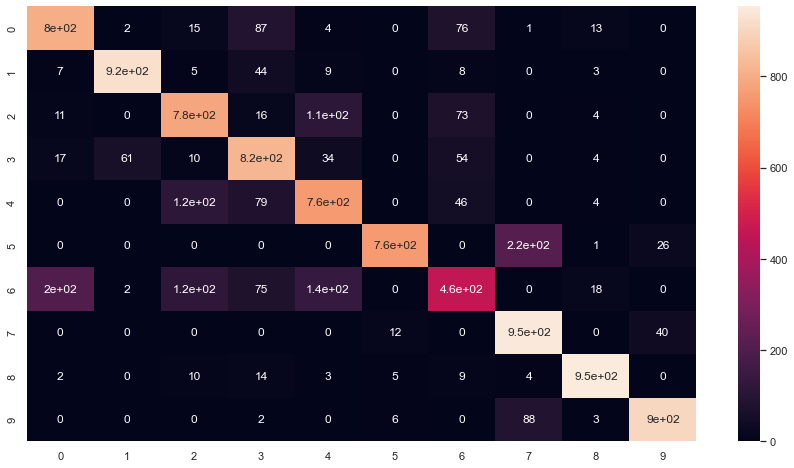

In [18]:
cf = confusion_matrix(target_te,pred)
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(cf, annot=True)


In [19]:
print("class  accuracy")
for i in range(len(cf)):
    rowsum = sum(cf[i])   
    
    print(" ", i,"   ",cf[i][i]/rowsum)

class  accuracy
  0     0.802
  1     0.924
  2     0.784
  3     0.82
  4     0.756
  5     0.758
  6     0.455
  7     0.948
  8     0.953
  9     0.901
